In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision

In [0]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

local_download_path = os.path.expanduser('./')

file_list = drive.ListFile({'q': "title = 'Neural_Nets-demo'"}).GetList()
ignore = ['.ipynb_checkpoints','__pycache__','core','run_','-ubyte.gz']

subdirs = file_list
subdirs[0]['path'] = local_download_path
subdirs[0]['title'] = ''

def retrieve_folder_files(path_to_folder, folder):
  
    files = drive.ListFile({'q': "'"+folder['id']+"' in parents"}).GetList()
    
    try:
      os.makedirs(os.path.join(path_to_folder,folder['title']))
    except: pass
    
    subdirs = []
    
    for file in files:
      
      if all(s not in file['title'] for s in ignore) and all(s not in path_to_folder for s in ignore):
      
        if file['mimeType'][-6:] != 'folder':
          fname = os.path.join(os.path.join(path_to_folder, folder['title']),file['title'])
          print('Getting file:', fname)
          f_ = drive.CreateFile({'id': file['id']})
          f_.GetContentFile(fname)

        else:
          file['path'] = os.path.join(path_to_folder, folder['title'])
          subdirs.append(file)
    
    return(subdirs)

while len(subdirs) > 0:
  
  ssubdirs = []
  
  for folder in subdirs:
    ssubdirs += (retrieve_folder_files(folder['path'], folder))
      
  subdirs = ssubdirs

In [0]:
# import libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as utils

import numpy as np
import matplotlib.pyplot as plt
from math import ceil

In [4]:
model_root_dir = './'

# get data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(model_root_dir+'MNIST_data', one_hot=False)

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


In [0]:
# Hyperparams
image_size = 28
num_classes = 10

batch_size = 100
learning_rate = 0.2
dropout_rate = 0.4

epochs = 2

if torch.cuda.is_available():
  dtype = torch.cuda.FloatTensor
  long_dtype = torch.cuda.LongTensor
else:
  dtype = torch.FloatTensor
  long_dtype = torch.LongTensor

In [0]:
# create pytorch dataset with mnist data
training_dataset = utils.TensorDataset(torch.Tensor(mnist.train.images),torch.LongTensor(mnist.train.labels))

# create pytorch dataloader for extra features and ease of use in training loop
training_loader = utils.DataLoader(dataset=training_dataset,
                                   batch_size=batch_size,
                                   shuffle=True)

In [0]:
# define NN
class Net(nn.Module):
    
    def __init__(self, num_classes):
        super(Net, self).__init__()
        
        # define convolutional layers 1 and 2
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=8,kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=8,out_channels=16,kernel_size=5)
        
        # define fc layers 1 and 2, with 2 being the output layer
        self.fc1 = nn.Linear(16*4*4, 256)
        self.fc2 = nn.Linear(256, num_classes)
    
    # define forward pass
    def forward(self, x):
        
        x = x.view(-1,1,image_size,image_size)
        
        # apply conv1 and relu
        x = F.relu(self.conv1(x))
        # apply max pooling
        x = F.max_pool2d(input=x,kernel_size=(2,2),stride=2)
        
        # apply conv2 and relu
        x = F.relu(self.conv2(x))
        # apply max pooling
        x = F.max_pool2d(input=x,kernel_size=(2,2),stride=2)
        
        # flatten
        x = x.view(-1,16*4*4)
        
        # fc layer 1
        x = F.relu(self.fc1(x))
        # apply dropout to fc1
        x = F.dropout(input=x,p=dropout_rate,training=self.training)
        
        # output layer, with a fc
        out = self.fc2(x)
        
        return out

In [8]:
# set net to our Net with params
net = Net(num_classes)

# define loss function
loss_func = nn.CrossEntropyLoss() 
# define optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

if torch.cuda.is_available():
  net.cuda()
  loss_func.cuda()

RuntimeError: ignored

In [0]:
# create function to calculate accuracy
def get_accuracy(images,labels):
    
    test_x = Variable(torch.Tensor(images)).type(dtype)
    test_y = torch.LongTensor(labels).type(long_dtype)

    _outputs = net(test_x)
    _, _predicted = torch.max(_outputs.data, 1)
    
    num_correct = (_predicted.cpu() == test_y).sum()
    num_total = test_y.size(0)

    return(str(100.0 * num_correct/num_total)+'%')

In [10]:
# calculate iterations to print as total steps
iterations = int(ceil(training_loader.dataset.target_tensor.size()[0]/float(batch_size)))

# initialize losses array
losses = np.array([])

for epoch in range(epochs):
    
    print('New epoch', str(epoch+1)+'/'+str(epochs))
    
    # for each batch in data loader
    for idx, (images, labels) in enumerate(training_loader):
        
        # set images and labels to variables so we can calculate the gradient
        images = Variable(images).type(dtype)
        labels = Variable(labels).type(long_dtype)

        # reset the parameter gradients
        optimizer.zero_grad()
        
        # forward pass
        outputs = net(images)
        # calculate loss
        loss = loss_func(outputs, labels)
        # calculate parameter gradients
        loss.backward()
        # update weights
        optimizer.step()

        if (idx+1) % 50 == 0:
            # set to evaluating mode, to avoid dropout
            net.eval()
            # calculate validation accuracy
            _accuracy = get_accuracy(mnist.validation.images, mnist.validation.labels)
            # print current status
            print('step', str(idx+1)+'/'+str(iterations), 'loss', loss.data[0], 'accuracy', _accuracy)
            
            # set back to training mode
            net.train()
            
        # append current loss to losses array to plot
        losses = np.append(losses, loss.data[0])

New epoch 1/2
step 50/550 loss 0.9272112250328064 accuracy 40.76%
step 100/550 loss 0.2161596715450287 accuracy 91.9%
step 150/550 loss 0.21559907495975494 accuracy 94.8%
step 200/550 loss 0.12949664890766144 accuracy 95.36%
step 250/550 loss 0.1617032289505005 accuracy 95.56%
step 300/550 loss 0.10020692646503448 accuracy 95.96%
step 350/550 loss 0.20717613399028778 accuracy 96.32%
step 400/550 loss 0.16145673394203186 accuracy 97.12%
step 450/550 loss 0.11637578904628754 accuracy 97.14%
step 500/550 loss 0.052437737584114075 accuracy 97.62%
step 550/550 loss 0.10648604482412338 accuracy 97.26%
New epoch 2/2
step 50/550 loss 0.161888986825943 accuracy 97.56%
step 100/550 loss 0.06967446953058243 accuracy 97.7%
step 150/550 loss 0.030621198937296867 accuracy 98.02%
step 200/550 loss 0.09396392107009888 accuracy 97.88%
step 250/550 loss 0.04501338303089142 accuracy 97.92%
step 300/550 loss 0.21175187826156616 accuracy 98.14%
step 350/550 loss 0.1574784219264984 accuracy 97.86%
step 400/

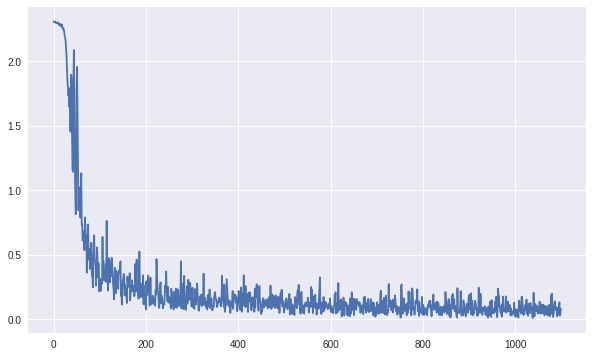

In [11]:
# plot losses
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(losses)
ax.grid(True)

In [12]:
# show evaluation accuracy
net.eval()
print(get_accuracy(mnist.test.images,mnist.test.labels))

98.41%


prediction: 2 answer: 2
0 0.0%
1 0.02%
2 99.98%
3 0.0%
4 0.0%
5 0.0%
6 0.0%
7 0.0%
8 0.0%
9 0.0%


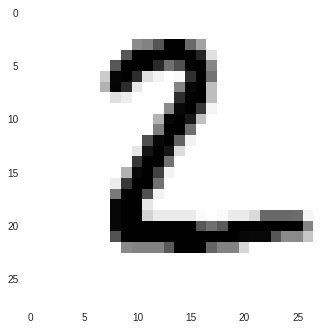

prediction: 6 answer: 6
0 0.06%
1 0.0%
2 0.0%
3 0.0%
4 0.0%
5 0.07%
6 99.86%
7 0.0%
8 0.01%
9 0.0%


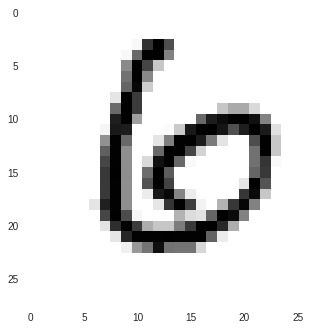

In [13]:
# test and show test images
test_idxs = [1,11]

for test_idx in test_idxs:
    test_x = Variable(torch.Tensor(mnist.test.images[test_idx].reshape(1,-1))).type(dtype)
    test_y = mnist.test.labels[test_idx]

    _prediction = net(test_x)

    print('prediction:', np.argmax(_prediction.cpu().data.numpy()), 'answer:', test_y)

    for i,val in enumerate(_prediction[0]):
        print(i, str(round(float(100*np.exp(val)/np.sum(np.exp(_prediction))),2))+'%')

    plt.imshow(test_x.cpu().data.numpy().reshape(image_size,image_size), cmap='binary')
    plt.grid(False)
    plt.show()